# PISA 2022 UK Data

While decision trees overfit the data, it is like that ensemble methods (e.g. bagging) will produce smoother, more generalisable boundaries. 
Bagging is one of the simplest and most effective ways to improve the performance of high-variance models like decision trees. Each tree is trained on a different bootstrap sample to introduce variablity among the models. The underlying algorithm remains the same but each tree encounters a slightly different subset of the data including repeated points and missing examples. The RandomForestClassifier trains each tree on a bootstrap sample and combines their predictions by majority vote, it also adds another source of randomness using feature substitution where it chooses a subset of features at each split. 

## 0. Import libraries, load and split data

In [ ]:
#Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Load and split data 

In [2]:
train_df = pd.read_csv("/workspaces/mini_project_2/data/processed/train.csv")
val_df   = pd.read_csv("/workspaces/mini_project_2/data/processed/val.csv")
test_df  = pd.read_csv("/workspaces/mini_project_2/data/processed/test.csv")

In [3]:
X_train = train_df.drop(columns=["target", "sample_weight"])
y_train = train_df["target"]
w_train = train_df["sample_weight"]

X_val = val_df.drop(columns=["target", "sample_weight"])
y_val = val_df["target"]
w_val = val_df["sample_weight"]

X_test = test_df.drop(columns=["target", "sample_weight"])
y_test = test_df["target"]
w_test = test_df["sample_weight"]

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7782, 21)
(2595, 21)
(7782,)
(2595,)


In [73]:
list(X_train.columns)

['gender',
 'life_sat',
 'math_hwork',
 'SES',
 'num_sib',
 'food_sec',
 'family_stat',
 'has_computer',
 'has_books',
 'schl_belong',
 'teacher_help',
 'safe_student',
 'safe_class',
 'qual_math_instruct',
 'make_friends',
 'feel_included',
 'no_mock',
 'region_england',
 'region_n_ireland',
 'region_scotland',
 'region_wales']

# 1. Train a Random Forest 

#### 1.1. Basic Random Forest Classifier

RandomForestClassifier builds many decision trees (ensemble) and combines them (by majority vote for classification). 

In [16]:
# Train a Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rfc.fit(X_train, y_train, sample_weight=w_train)

RandomForestClassifier(random_state=42)

In [34]:
# Evaluate accuracy
rf_preds = rfc.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds, sample_weight=w_test)

In [35]:
#Accuracy: Number of correct predictions/total number of predictions
print(f"Test Accuracy:, {rf_acc:.2%}")

Test Accuracy:, 65.80%


- The Random Forest classifier achieved a test accuracy of **67.17%**, indicating moderate predictive performance on this dataset.

In [37]:
print("Classification Report:")
print(classification_report(y_test, rf_preds, sample_weight=w_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.60      0.63 69579.26632999988
           1       0.66      0.71      0.68 75928.20554999997

    accuracy                           0.66 145507.47187999985
   macro avg       0.66      0.66      0.66 145507.47187999985
weighted avg       0.66      0.66      0.66 145507.47187999985



- The Random Forest classifier achieved balanced performance across classes, with precision, recall, and F1-scores all around **67%**, indicating moderately effective classification likely constrained by data complexity rather than overfitting, and without strong class bias.


Confusion Matrix:


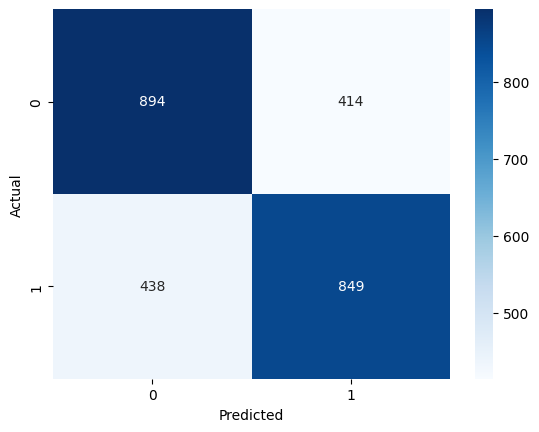

In [71]:
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. Feature Importance 

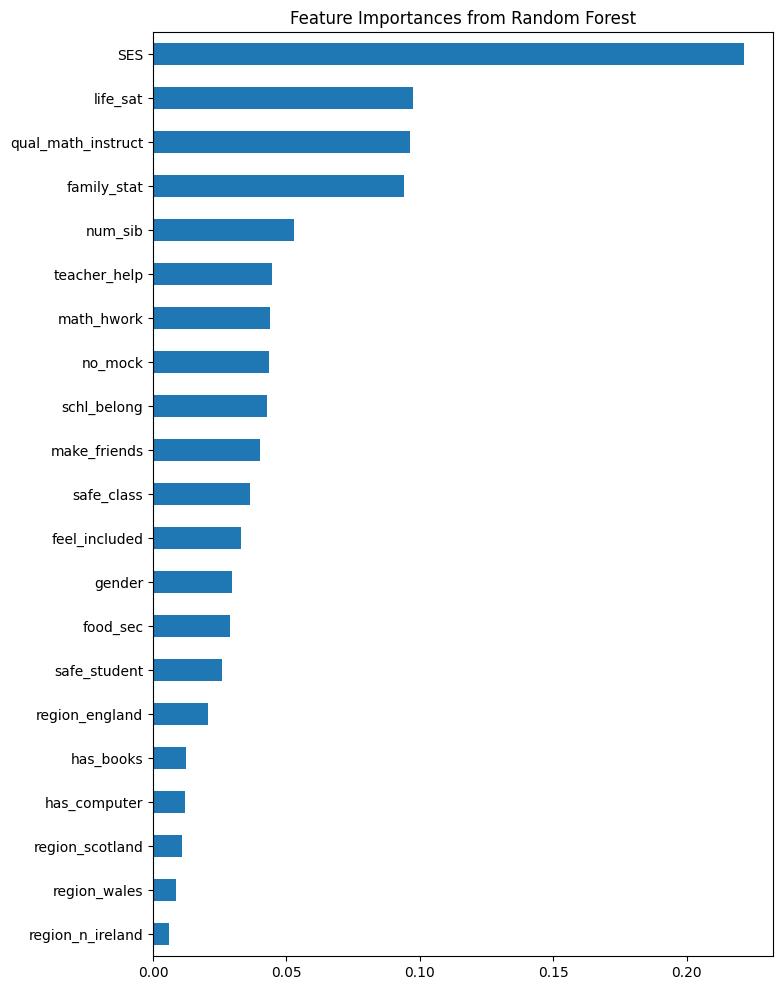

In [24]:
importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,12))
plt.title("Feature Importances from Random Forest")
plt.show()

- **Feature importance analysis** revealed that socioeconomic status (`SES`) was the dominant predictor, with secondary contributions from life satisfaction, classroom instruction, and family status, while most other features had minimal impact on model decisions.  
- **Next steps:** first, try hyperparameter tuning on the **full feature set** to optimize performance. Then, based on feature importance, retrain using only the **top features** to see if performance holds, improving interpretability and comput

# 3. Explore max_features tuning 

In [38]:
accuracies = []
feature_splits = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for split in feature_splits:
    rfc_split = RandomForestClassifier(n_estimators=100, max_features=split, random_state=42)
    rfc_split.fit(X_train, y_train, sample_weight=w_train)
    preds = rfc_split.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    
    print(f"max_features: {split:.1f} -> Test Accuracy: {acc:.2%}")

max_features: 0.2 -> Test Accuracy: 67.17%
max_features: 0.3 -> Test Accuracy: 66.90%
max_features: 0.4 -> Test Accuracy: 66.90%
max_features: 0.5 -> Test Accuracy: 66.78%
max_features: 0.6 -> Test Accuracy: 67.01%
max_features: 0.7 -> Test Accuracy: 65.97%
max_features: 0.8 -> Test Accuracy: 66.63%
max_features: 0.9 -> Test Accuracy: 66.74%
max_features: 1.0 -> Test Accuracy: 66.71%


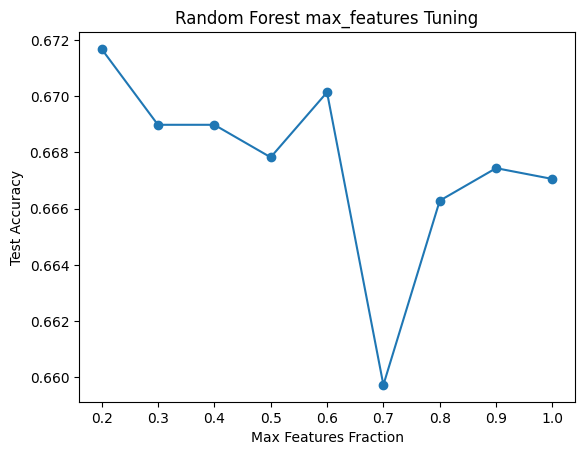

In [39]:
plt.plot(feature_splits, accuracies, marker='o')
plt.ylabel('Test Accuracy')
plt.xlabel('Max Features Fraction')
plt.title('Random Forest max_features Tuning')
plt.show()


- **Random Forest `max_features` tuning:**  
  Varying the fraction of features considered at each split showed that setting `max_features` to **0.2 (20%)** yielded the highest test accuracy at **67.17%**, slightly outperforming higher values. This suggests that using fewer features per split increases tree diversity, improving generalization on this dataset.

# 4. Tuning n_estimators 

In [44]:
n_estimators_list = [50, 100, 200, 500]
accuracies_n = []

for n in n_estimators_list:
    rfc_n = RandomForestClassifier(
        n_estimators=n,
        max_features=0.2,   # use your best so far
        random_state=42
    )
    rfc_n.fit(X_train, y_train, sample_weight=w_train)
    preds = rfc_n.predict(X_test)
    acc = accuracy_score(y_test, preds, sample_weight=w_test)
    accuracies_n.append(acc)
    
    print(f"n_estimators: {n} -> Test Accuracy: {acc:.2%}")

n_estimators: 50 -> Test Accuracy: 65.77%
n_estimators: 100 -> Test Accuracy: 65.80%
n_estimators: 200 -> Test Accuracy: 64.52%
n_estimators: 500 -> Test Accuracy: 64.77%


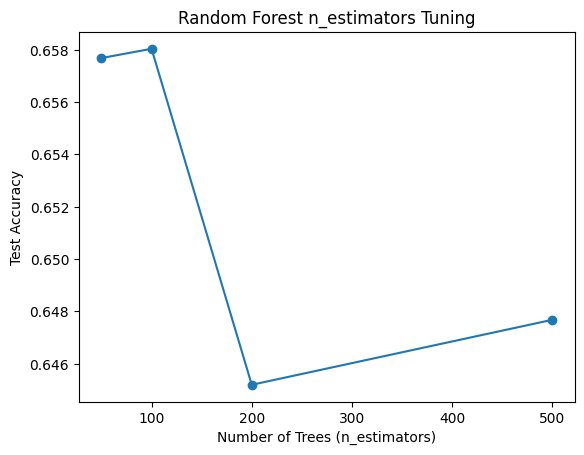

In [45]:
plt.plot(n_estimators_list, accuracies_n, marker='o')
plt.ylabel('Test Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.title('Random Forest n_estimators Tuning')
plt.show()

**Adding more trees (n_estimators) beyond ~100 did not improve test accuracy, suggesting performance plateaued; ~100 trees balances accuracy and efficiency well for this dataset.**

# 5. Explore max depth 

In [48]:
depth_list = [None, 10, 15, 20]
accuracies_depth = []

for depth in depth_list:
    rfc_depth = RandomForestClassifier(
        n_estimators=100,
        max_features=0.2,
        max_depth=depth,
        random_state=42
    )
    rfc_depth.fit(X_train, y_train, sample_weight=w_train)
    preds = rfc_depth.predict(X_test)
    acc = accuracy_score(y_test, preds, sample_weight=w_test)
    accuracies_depth.append(acc)
    
    print(f"max_depth: {depth} -> Test Accuracy: {acc:.2%}")

max_depth: None -> Test Accuracy: 65.80%
max_depth: 10 -> Test Accuracy: 66.21%
max_depth: 15 -> Test Accuracy: 65.32%
max_depth: 20 -> Test Accuracy: 65.95%


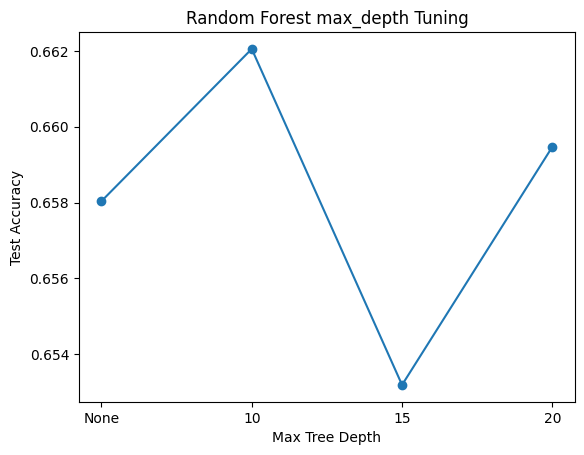

In [49]:
plt.plot(
    ['None' if d is None else str(d) for d in depth_list],
    accuracies_depth,
    marker='o'
)
plt.ylabel('Test Accuracy')
plt.xlabel('Max Tree Depth')
plt.title('Random Forest max_depth Tuning')
plt.show()

- **Random Forest `max_depth` tuning:**  
  Testing different maximum tree depths showed that setting `max_depth=10` yielded the best test accuracy at **66.21%**, slightly outperforming deeper trees. This suggests that limiting tree depth helped balance under- and overfitting for this dataset, while very deep trees (`max_depth=None` or `20`) did not improve performance and may have captured more noise.

# 6. Explore min_samples_split tuning 

In [50]:
split_list = [2, 5, 10]
accuracies_split = []

for split in split_list:
    rfc_split = RandomForestClassifier(
        n_estimators=100,
        max_features=0.2,
        max_depth=10,
        min_samples_split=split,
        random_state=42
    )
    rfc_split.fit(X_train, y_train, sample_weight=w_train)
    preds = rfc_split.predict(X_test)
    acc = accuracy_score(y_test, preds, sample_weight=w_test)
    accuracies_split.append(acc)
    
    print(f"min_samples_split: {split} -> Test Accuracy: {acc:.2%}")

min_samples_split: 2 -> Test Accuracy: 66.21%
min_samples_split: 5 -> Test Accuracy: 65.64%
min_samples_split: 10 -> Test Accuracy: 66.04%


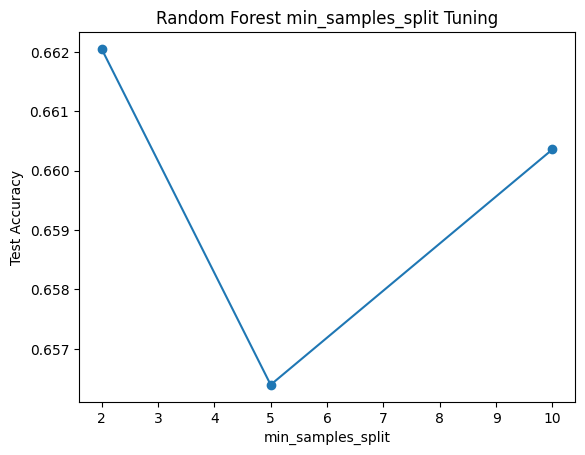

In [51]:
plt.plot(split_list, accuracies_split, marker='o')
plt.ylabel('Test Accuracy')
plt.xlabel('min_samples_split')
plt.title('Random Forest min_samples_split Tuning')
plt.show()

- **Random Forest `min_samples_split` tuning:**  
  Testing different minimum samples required to split an internal node showed that keeping `min_samples_split=2` achieved the best test accuracy at **66.21%**. Slightly larger values (5 and 10) led to marginal decreases in performance, suggesting that allowing smaller splits helped the trees better capture patterns in this dataset without significant overfitting.

# 7. Explore min_samples_leaf

In [52]:
leaf_list = [1, 2, 5]
accuracies_leaf = []

for leaf in leaf_list:
    rfc_leaf = RandomForestClassifier(
        n_estimators=100,
        max_features=0.2,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=leaf,
        random_state=42
    )
    rfc_leaf.fit(X_train, y_train, sample_weight=w_train)
    preds = rfc_leaf.predict(X_test)
    acc = accuracy_score(y_test, preds, sample_weight=w_test)
    accuracies_leaf.append(acc)
    
    print(f"min_samples_leaf: {leaf} -> Test Accuracy: {acc:.2%}")

min_samples_leaf: 1 -> Test Accuracy: 66.21%
min_samples_leaf: 2 -> Test Accuracy: 64.78%
min_samples_leaf: 5 -> Test Accuracy: 65.85%


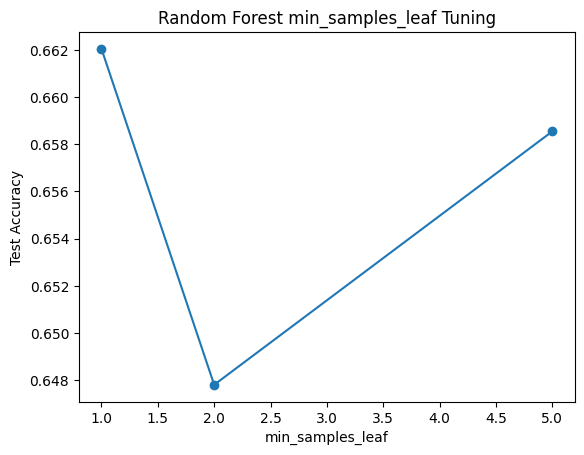

In [53]:
plt.plot(leaf_list, accuracies_leaf, marker='o')
plt.ylabel('Test Accuracy')
plt.xlabel('min_samples_leaf')
plt.title('Random Forest min_samples_leaf Tuning')
plt.show()

- **Random Forest `min_samples_leaf` tuning:** Best test accuracy (**66.21%**) was achieved with `min_samples_leaf=1`, while larger values slightly reduced performance, indicating finer splits were beneficial for this data.

# 8. Final model with best hyperparameters 

In [55]:
final_rfc = RandomForestClassifier(
    n_estimators=100,
    max_features=0.2,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
final_rfc.fit(X_train, y_train, sample_weight=w_train)

RandomForestClassifier(max_depth=10, max_features=0.2, random_state=42)

In [56]:
final_preds = final_rfc.predict(X_test)
final_acc = accuracy_score(y_test, final_preds, sample_weight=w_test)
print(f"\nFinal Model Test Accuracy: {final_acc:.2%}")


Final Model Test Accuracy: 66.21%


In [57]:
print("\nClassification Report:")
print(classification_report(y_test, final_preds, sample_weight=w_test))


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66 69579.26632999988
           1       0.69      0.65      0.67 75928.20554999997

    accuracy                           0.66 145507.47187999985
   macro avg       0.66      0.66      0.66 145507.47187999985
weighted avg       0.66      0.66      0.66 145507.47187999985




Confusion Matrix:


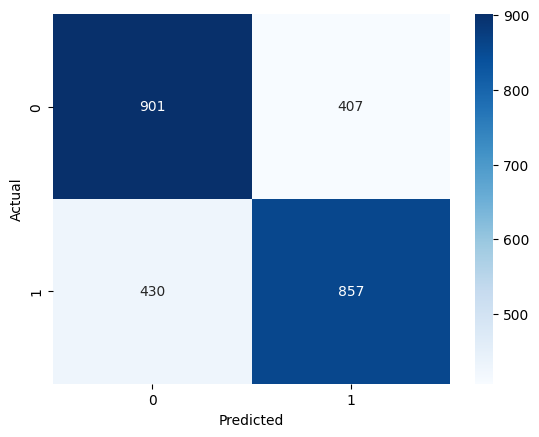

In [58]:
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 9. Rerun feature importance 

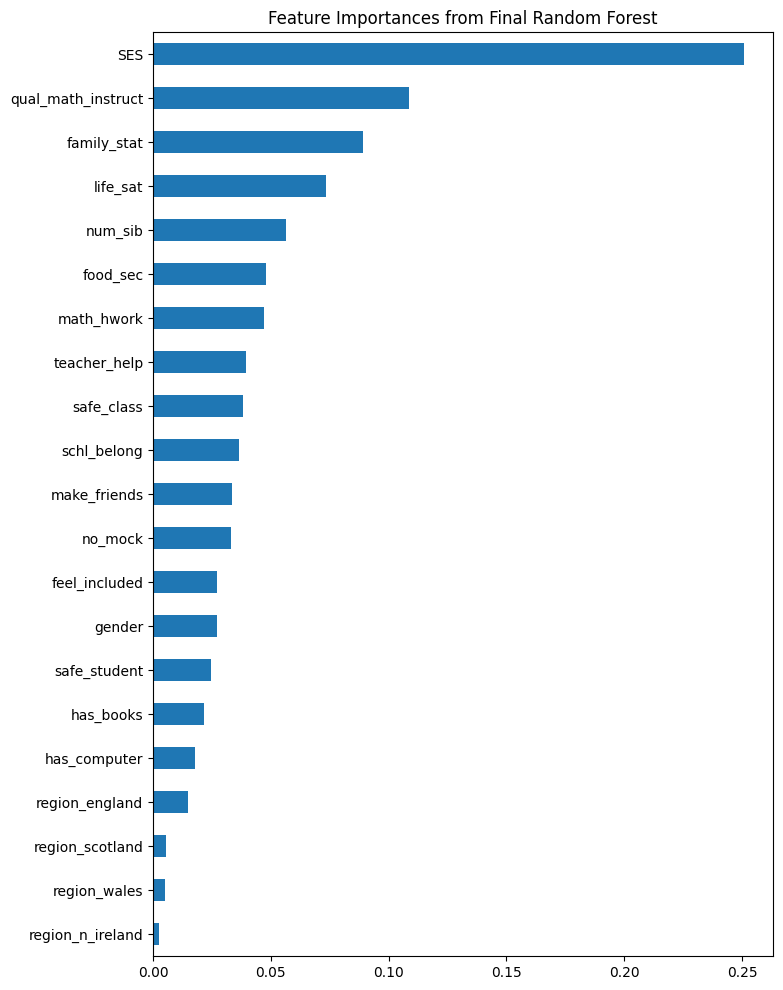

In [59]:
importances_final = pd.Series(final_rfc.feature_importances_, index=X_train.columns)
importances_final.sort_values(ascending=True).plot(kind='barh', figsize=(8,12))
plt.title("Feature Importances from Final Random Forest")
plt.show()

In [60]:
# Select top 5 features
top_features = importances_final.sort_values(ascending=False).head(5).index.tolist()
print(f"Top 5 features: {top_features}")

# Reduce training and test sets
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

Top 5 features: ['SES', 'qual_math_instruct', 'family_stat', 'life_sat', 'num_sib']


# 10. Identify optimum number of features 

In [65]:
importances_sorted = importances_final.sort_values(ascending=False)
feature_counts = list(range(3, len(importances_sorted)+1, 2))  # try 3,5,7,... up to all
accuracies_vs_features = []

for count in feature_counts:
    top_feats = importances_sorted.head(count).index.tolist()
    X_train_top = X_train[top_feats]
    X_test_top = X_test[top_feats]

    rfc_top = RandomForestClassifier(
        n_estimators=100,
        max_features=0.2,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
    rfc_top.fit(X_train_top, y_train, sample_weight=w_train)
    preds_top = rfc_top.predict(X_test_top)
    acc = accuracy_score(y_test, preds_top, sample_weight=w_test)
    accuracies_vs_features.append(acc)

    print(f"Top {count} features -> Test Accuracy: {acc:.2%}")

Top 3 features -> Test Accuracy: 63.59%
Top 5 features -> Test Accuracy: 64.67%
Top 7 features -> Test Accuracy: 64.78%
Top 9 features -> Test Accuracy: 65.66%
Top 11 features -> Test Accuracy: 65.64%
Top 13 features -> Test Accuracy: 66.07%
Top 15 features -> Test Accuracy: 64.98%
Top 17 features -> Test Accuracy: 64.68%
Top 19 features -> Test Accuracy: 66.42%
Top 21 features -> Test Accuracy: 66.81%


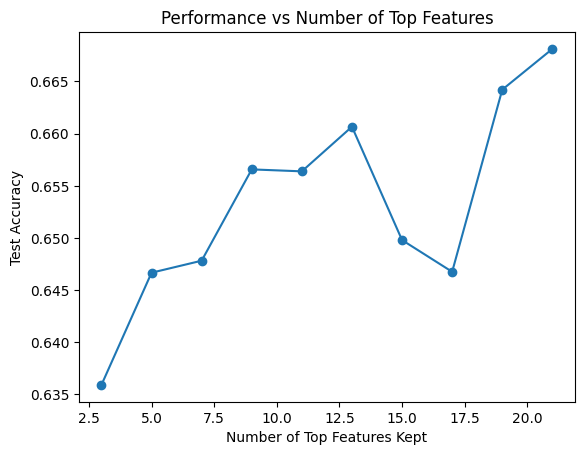

In [66]:
# Plot the results
plt.plot(feature_counts, accuracies_vs_features, marker='o')
plt.xlabel("Number of Top Features Kept")
plt.ylabel("Test Accuracy")
plt.title("Performance vs Number of Top Features")
plt.show()

- **Optimal number of features:**  
  Incrementally adding top features showed that test accuracy continued to improve up to using **all 21 features**, with no clear plateau. This indicates that, for this dataset, retaining the full feature set maximizes predictive performance, likely due to small contributions from multiple variables that together refine the decision boundaries.

- **Why keep all features?**  
  Given the complex, multi-factor nature of educational outcomes, even small individual predictors likely contribute subtle patterns and interactions that improve the Random Forest’s decisions. Retaining all features captures these complementary effects, helping the model generalize better despite most predictive power being concentrated in a few dominant variables.

# 11. Final Model on reduced number of features 

In [67]:
final_model = RandomForestClassifier(
    n_estimators=100,
    max_features=0.2,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

final_model.fit(X_train, y_train, sample_weight=w_train)


RandomForestClassifier(max_depth=10, max_features=0.2, random_state=42)

In [68]:
# Evaluate on test set
final_preds = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_preds, sample_weight=w_test)

In [72]:
print(f"\n Final Model Test Accuracy: {final_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, final_preds, sample_weight=w_test))


 Final Model Test Accuracy: 66.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66 69579.26632999988
           1       0.69      0.65      0.67 75928.20554999997

    accuracy                           0.66 145507.47187999985
   macro avg       0.66      0.66      0.66 145507.47187999985
weighted avg       0.66      0.66      0.66 145507.47187999985




Confusion Matrix:


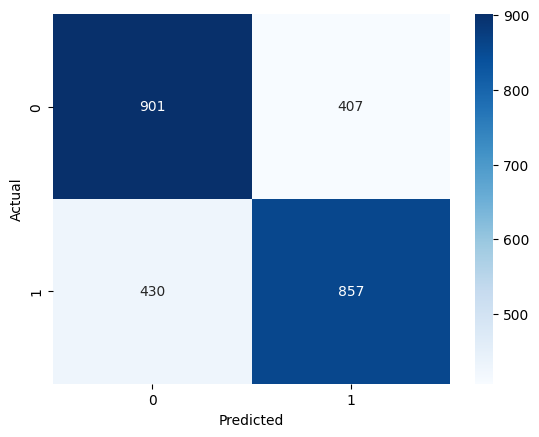

In [70]:
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 12. Final best minimalist model 

### Hyperparameter tuning summary
- **max_features=0.2** gave the biggest boost to accuracy (↑ to 67.17%), followed by **max_depth=10** (↑ to 66.21%), helping reduce overfitting.
  
- Other parameters (`n_estimators`, `min_samples_split`, `min_samples_leaf`) had minimal impact beyond defaults.

Focus on tuning **max_features** and **max_depth**, keeping others at sensible defaults for simplicity and interpretability.


In [84]:
final_min_model = RandomForestClassifier(
    max_features=0.2,
    max_depth=10,
    random_state=42
)

final_min_model.fit(X_train, y_train, sample_weight=w_train)

RandomForestClassifier(max_depth=10, max_features=0.2, random_state=42)

In [85]:
# Evaluate on test set
final_preds = final_min_model.predict(X_test)
final_acc = accuracy_score(y_test, final_preds, sample_weight=w_test)

In [86]:
print(f"\n Final Min Model Test Accuracy: {final_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, final_preds, sample_weight=w_test))


 Final Min Model Test Accuracy: 66.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66 69579.26632999988
           1       0.69      0.65      0.67 75928.20554999997

    accuracy                           0.66 145507.47187999985
   macro avg       0.66      0.66      0.66 145507.47187999985
weighted avg       0.66      0.66      0.66 145507.47187999985



# 12. Final check on validation set 

In [87]:
val_preds = final_min_model.predict(X_val)
val_acc = accuracy_score(y_val, val_preds, sample_weight=w_val)
print(f"\nFinal Model Validation Set Accuracy: {val_acc:.2%}")


Final Model Validation Set Accuracy: 63.19%



Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.66      0.61 65160.671740000005
           1       0.69      0.61      0.65 80249.1518299999

    accuracy                           0.63 145409.8235699999
   macro avg       0.63      0.63      0.63 145409.8235699999
weighted avg       0.64      0.63      0.63 145409.8235699999


Confusion Matrix:


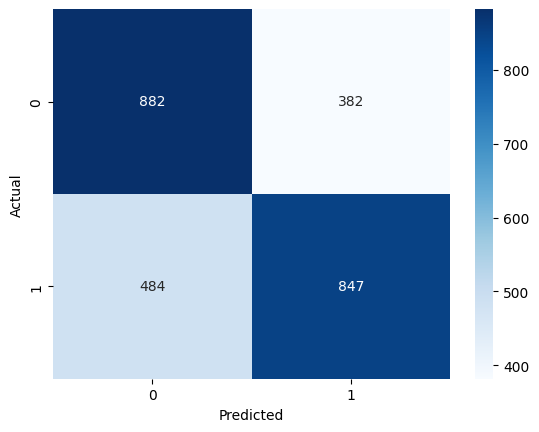

In [89]:
print("\nClassification Report:")
print(classification_report(y_val, val_preds, sample_weight=w_val))

print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- When evaluated on the validation set, the final Random Forest showed a slight drop in accuracy compared to the test set. This is expected due to natural data variability and reflects the typical trade-off between optimizing performance and ensuring generalization to truly unseen data.
